In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

### Подготовка данных

In [3]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [5]:
# устранение выбросов
Q1 = df['SI'].quantile(0.25)
Q3 = df['SI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['SI'] >= lower_bound) & (df['SI'] <= upper_bound)]

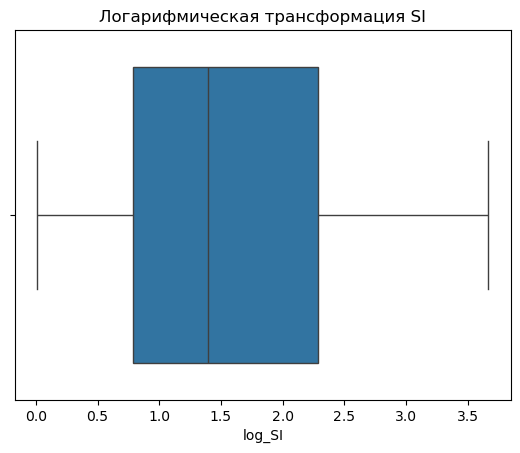

In [9]:
# Логарифмическая трансформация
df['log_SI'] = np.log(df['SI'] + 1)
sns.boxplot(x=df['log_SI'])
plt.title('Логарифмическая трансформация SI')
plt.show()

In [11]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,log_SI
0,6.239374,175.482382,28.125,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,3,0,3.371597
1,0.771831,5.402819,7.000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,3,0,2.079442
2,223.808778,161.142320,0.720,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,3,0,0.542324
4,107.131532,139.270991,1.300,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0.832909
5,15.037911,30.075821,2.000,5.758408,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,...,0,0,0,0,0,0,0,0,0,1.098612


In [13]:
df = df.drop(df.columns[[0]], axis=1)

In [15]:
df = df.drop(df.columns[[0]], axis=1)

In [17]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,log_SI
0,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,...,0,0,0,0,0,0,0,3,0,3.371597
1,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,...,0,0,0,0,0,0,0,3,0,2.079442
2,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,...,0,0,0,0,0,0,0,3,0,0.542324
4,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,...,0,0,0,0,0,0,0,0,0,0.832909
5,5.758408,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,304.267,332.225249,130,...,0,0,0,0,0,0,0,0,0,1.098612


In [19]:
# добавление фичей
df['Mol_properties_ratio'] = df['HeavyAtomMolWt'] / df['MolWt']
df['Electron_density'] = df['NumValenceElectrons'] / df['HeavyAtomCount']

df['Charge_imbalance'] = df['MaxPartialCharge'] - df['MinPartialCharge']
df['Abs_charge_range'] = df['MaxAbsPartialCharge'] - df['MinAbsPartialCharge']

df['Topological_complexity'] = df['Chi0'] + df['Chi1'] + df['Kappa1'] + df['Kappa2']
peoe_cols = [col for col in df.columns if 'PEOE_VSA' in col]
smr_cols = [col for col in df.columns if 'SMR_VSA' in col]

df['PEOE_VSA_total'] = df[peoe_cols].sum(axis=1)
df['SMR_VSA_total'] = df[smr_cols].sum(axis=1)

fr_cols = [col for col in df.columns if col.startswith('fr_')]
df['Functional_groups_total'] = df[fr_cols].sum(axis=1)

df['H_bond_groups'] = df['NumHAcceptors'] + df['NumHDonors']

df['Ring_complexity'] = (
    df['NumAromaticRings']
    + df['NumAliphaticRings']
    + df['NumSaturatedRings']
)

# удаление исходных фичей
columns_to_drop = peoe_cols + smr_cols + fr_cols + [
    'HeavyAtomMolWt', 'MolWt', 'NumValenceElectrons', 'HeavyAtomCount',
    'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
    'Chi0', 'Chi1', 'Kappa1', 'Kappa2',
    'NumHAcceptors', 'NumHDonors',
    'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings'
]

df.drop(columns=columns_to_drop, inplace=True)

In [21]:
# анализ мультиколинеарности и отбор фичей
target_vars = ['log_SI']
numeric_features = df.select_dtypes(include=np.number)

# анализ корреляционной матрицы между признаками
corr_matrix = numeric_features.corr()
# пары признаков с высокой корреляцией (>0.8 или <-0.8)
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]
print("Пары признаков с высокой корреляцией (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")

# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features.columns

vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]
print("\nПризнаки с высоким VIF (более 5):")
for index, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['feature']}: VIF = {row['VIF']:.2f}")

# корреляция признаков с целевыми переменными
corr_with_targets = pd.DataFrame(index=numeric_features.columns)
for target in target_vars:
    corr_with_targets[target] = numeric_features.corrwith(df[target])

# удаление признаков
features_to_remove = set()
for col1, col2, corr_value in high_corr_pairs:
    # проверка наличия высокой корреляции с таргетом у каждого признака
    corr_col1_targets = corr_with_targets.loc[col1].abs()
    corr_col2_targets = corr_with_targets.loc[col2].abs()

    col1_has_target_corr = any(corr_col1_targets > 0.2)
    col2_has_target_corr = any(corr_col2_targets > 0.2)
    if not col1_has_target_corr and not col2_has_target_corr:
        features_to_remove.add(col2)
print("\nПризнаки для удаления из-за мультиколлинеарности без связи с таргетом:")
for feature in features_to_remove:
    print(feature)

# итоговый набор признаков после удаления
final_features = [col for col in numeric_features.columns if col not in features_to_remove]
print("\nОставшиеся признаки после удаления:")
print(final_features)

df_final = df[final_features]

Пары признаков с высокой корреляцией (>0.8):
MaxAbsEStateIndex и MaxEStateIndex: корреляция = 1.00
MaxEStateIndex и MaxAbsEStateIndex: корреляция = 1.00
SPS и FractionCSP3: корреляция = 0.86
ExactMolWt и BertzCT: корреляция = 0.90
ExactMolWt и Chi0n: корреляция = 0.94
ExactMolWt и Chi0v: корреляция = 0.95
ExactMolWt и Chi1n: корреляция = 0.90
ExactMolWt и Chi1v: корреляция = 0.93
ExactMolWt и LabuteASA: корреляция = 0.99
ExactMolWt и MolMR: корреляция = 0.96
ExactMolWt и Topological_complexity: корреляция = 0.98
ExactMolWt и PEOE_VSA_total: корреляция = 0.99
ExactMolWt и SMR_VSA_total: корреляция = 0.99
ExactMolWt и Functional_groups_total: корреляция = 0.81
FpDensityMorgan1 и FpDensityMorgan2: корреляция = 0.95
FpDensityMorgan1 и FpDensityMorgan3: корреляция = 0.80
FpDensityMorgan2 и FpDensityMorgan1: корреляция = 0.95
FpDensityMorgan2 и FpDensityMorgan3: корреляция = 0.94
FpDensityMorgan3 и FpDensityMorgan1: корреляция = 0.80
FpDensityMorgan3 и FpDensityMorgan2: корреляция = 0.94
BCU

In [22]:
df_final.head()

,MinAbsEStateIndex,MinEStateIndex,qed,NumRadicalElectrons,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,SlogP_VSA1,SlogP_VSA10,...,VSA_EState7,VSA_EState8,VSA_EState9,NumAliphaticHeterocycles,NumAromaticHeterocycles,NumSaturatedHeterocycles,MolLogP,log_SI,Charge_imbalance,Abs_charge_range
0,0.387225,0.387225,0.417362,0,0.193481,3.150503,1.164038,2.187750e+06,0.000000,0.000000,...,13.258223,16.981087,0.000000,0,0,0,7.1212,3.371597,0.332369,0.254682
1,0.533868,0.533868,0.462473,0,0.120322,3.150503,1.080362,2.187750e+06,10.633577,0.000000,...,14.135381,17.670565,0.000000,0,0,0,6.1556,2.079442,0.326294,0.300521
2,0.543231,0.543231,0.260923,0,-0.922902,3.214947,1.219066,8.610751e+06,0.000000,0.000000,...,14.491619,18.287216,10.183618,0,0,0,7.1292,0.542324,0.420375,0.230772
4,0.270476,0.270476,0.429038,0,0.193687,3.337074,1.136678,1.053758e+08,0.000000,11.374773,...,8.627311,14.692318,0.000000,0,0,0,9.1148,0.832909,0.320137,0.194342
5,0.278083,0.278083,0.711012,0,0.193701,2.920513,1.523516,6.287748e+05,5.733667,11.374773,...,4.766280,7.291772,0.000000,0,0,0,5.7783,1.098612,0.461626,0.335831


In [25]:
# 20 самых важных признаков
X = df_final.drop(columns=['log_SI'])
y = df_final['log_SI']

importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("20 самых важных признаков для SI по их значимости:")
print(feature_importances.head(20))

20 самых важных признаков для SI по их значимости:
BCUT2D_MRLOW         0.181473
AvgIpc               0.180312
SlogP_VSA5           0.150994
qed                  0.139363
VSA_EState4          0.136192
EState_VSA9          0.131405
Abs_charge_range     0.130427
EState_VSA2          0.128931
MinAbsEStateIndex    0.126851
VSA_EState8          0.126092
VSA_EState7          0.122338
Charge_imbalance     0.121891
SlogP_VSA2           0.120766
VSA_EState5          0.118041
MinEStateIndex       0.114764
EState_VSA5          0.113003
VSA_EState1          0.109122
MolLogP              0.105637
EState_VSA8          0.104608
VSA_EState2          0.094408
dtype: float64


In [27]:
# Удаляем признаки с важностью менее 0.05
features_to_keep = feature_importances[feature_importances >= 0.05].index
X_drop = X[features_to_keep]

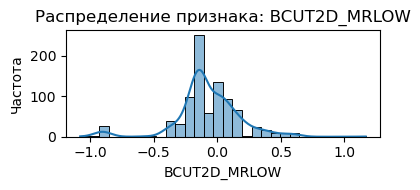

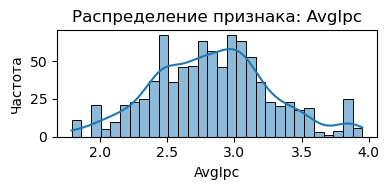

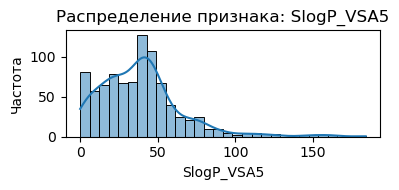

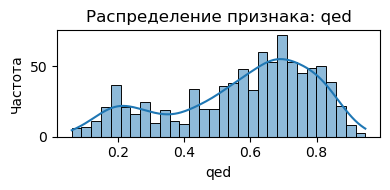

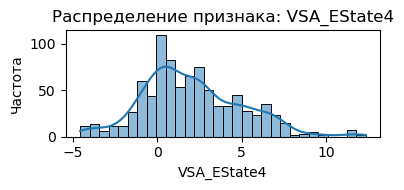

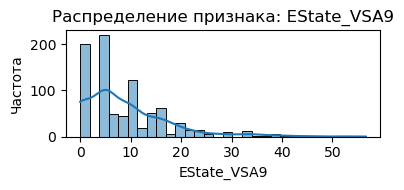

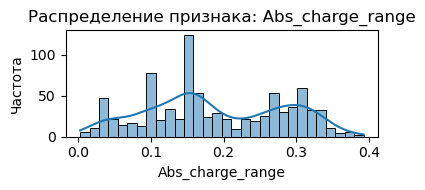

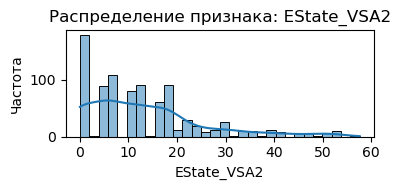

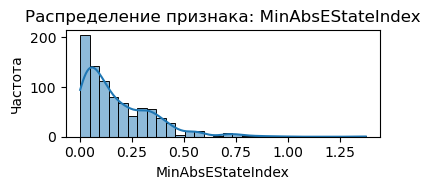

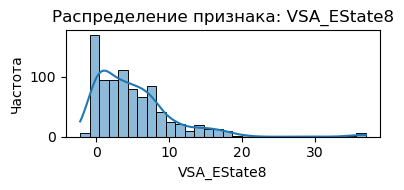

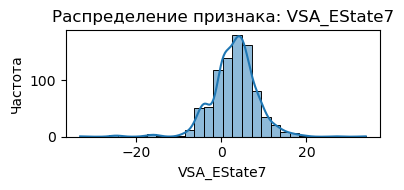

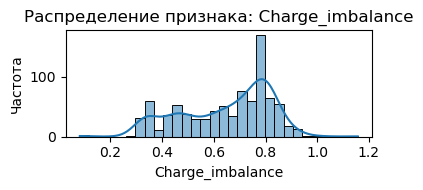

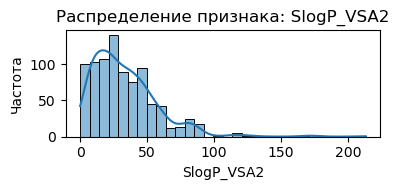

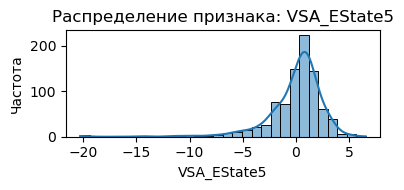

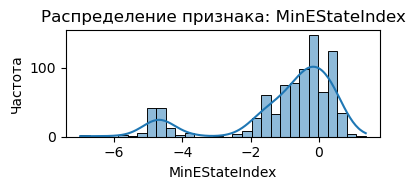

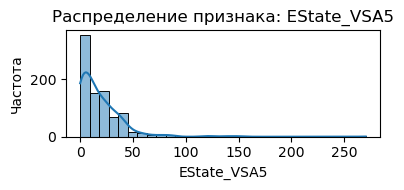

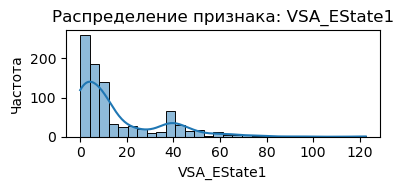

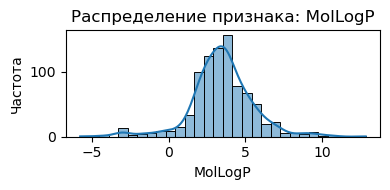

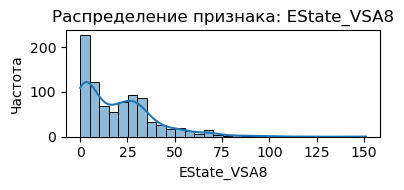

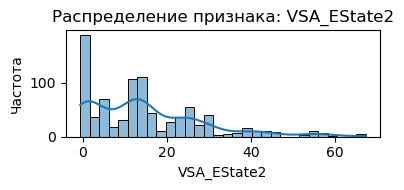

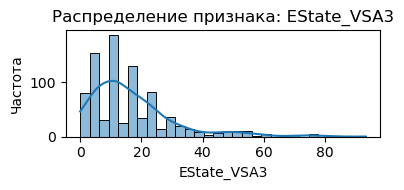

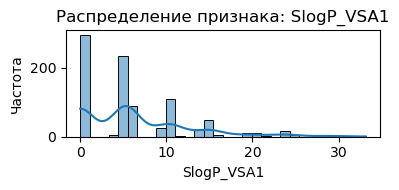

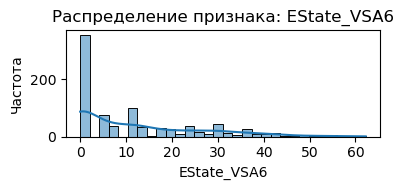

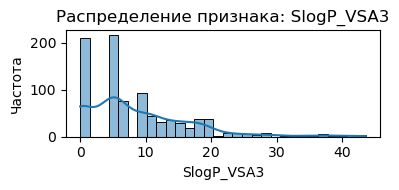

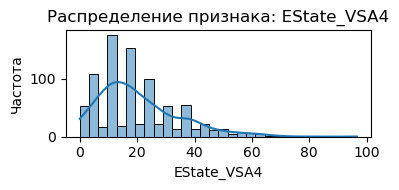

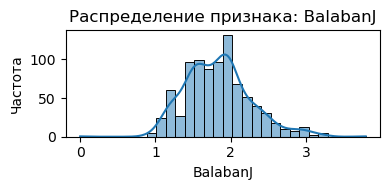

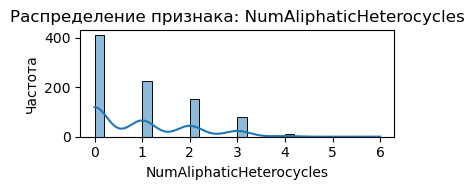

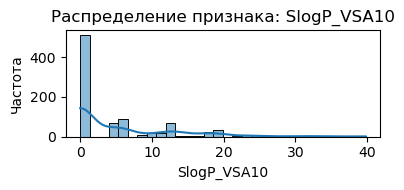

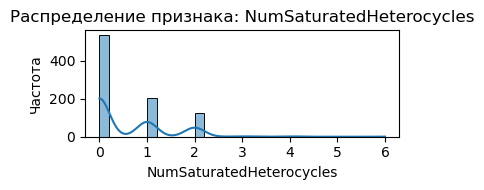

In [29]:
# построение графиков распределения оставшихся признаков
for feature in features_to_keep:
    plt.figure(figsize=(4, 2))
    sns.histplot(X_drop[feature], bins=30, kde=True)
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.tight_layout() 
    plt.show()

In [31]:
# логарифмизация признаков
skewness = X_drop.skew()
print(skewness[skewness.abs() > 1])
features_to_log = skewness[skewness > 1].index

print("Признаки для логарифмирования SI:", list(features_to_log))

for feature in features_to_log:
    min_value = X_drop[feature].min()
    if min_value <= 0:
        shift_value = abs(min_value) + 1e-9
        X_drop[feature] = np.log(X_drop[feature] + shift_value)
    else:
        X_drop[feature] = np.log(X_drop[feature])

SlogP_VSA5                  1.439756
EState_VSA9                 1.666056
EState_VSA2                 1.245235
MinAbsEStateIndex           1.658144
VSA_EState8                 2.390408
SlogP_VSA2                  1.805568
VSA_EState5                -2.688860
MinEStateIndex             -1.550153
EState_VSA5                 3.642878
VSA_EState1                 1.697929
EState_VSA8                 1.485438
VSA_EState2                 1.175609
EState_VSA3                 1.760583
SlogP_VSA1                  1.263467
EState_VSA6                 1.131264
SlogP_VSA3                  1.345288
EState_VSA4                 1.099904
SlogP_VSA10                 1.710619
NumSaturatedHeterocycles    1.502712
dtype: float64
Признаки для логарифмирования SI: ['SlogP_VSA5', 'EState_VSA9', 'EState_VSA2', 'MinAbsEStateIndex', 'VSA_EState8', 'SlogP_VSA2', 'EState_VSA5', 'VSA_EState1', 'EState_VSA8', 'VSA_EState2', 'EState_VSA3', 'SlogP_VSA1', 'EState_VSA6', 'SlogP_VSA3', 'EState_VSA4', 'SlogP_VSA10', 'NumS

In [33]:
# замена выбросов на границы интервала (IQR) для всех признаков
for feature in X_drop.columns:
    Q1 = X_drop[feature].quantile(0.25)
    Q3 = X_drop[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before_values = X_drop[feature].copy()
    X_drop.loc[X_drop[feature] < lower_bound, feature] = lower_bound
    X_drop.loc[X_drop[feature] > upper_bound, feature] = upper_bound
    
    num_lower_replacements = (before_values < lower_bound).sum()
    num_upper_replacements = (before_values > upper_bound).sum()
    
    print(f"В признаке '{feature}': заменено {num_lower_replacements} значений ниже нижней границы и {num_upper_replacements} выше верхней границы.")

В признаке 'BCUT2D_MRLOW': заменено 31 значений ниже нижней границы и 31 выше верхней границы.
В признаке 'AvgIpc': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'SlogP_VSA5': заменено 43 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'qed': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'VSA_EState4': заменено 0 значений ниже нижней границы и 10 выше верхней границы.
В признаке 'EState_VSA9': заменено 200 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'Abs_charge_range': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'EState_VSA2': заменено 178 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'MinAbsEStateIndex': заменено 23 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'VSA_EState8': заменено 4 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'VSA_EState7': заменено 12 значений ниже нижней границы и 13 в

In [35]:
X_drop.head()

,BCUT2D_MRLOW,AvgIpc,SlogP_VSA5,qed,VSA_EState4,EState_VSA9,Abs_charge_range,EState_VSA2,MinAbsEStateIndex,VSA_EState8,...,VSA_EState2,EState_VSA3,SlogP_VSA1,EState_VSA6,SlogP_VSA3,EState_VSA4,BalabanJ,NumAliphaticHeterocycles,SlogP_VSA10,NumSaturatedHeterocycles
0,0.193481,3.150503,4.661084,0.417362,4.807589,2.301065,0.254682,-0.019272,-0.948750,2.954484,...,2.377852,3.075465,-20.723266,2.435661,0.059398,3.215884,1.164038,0,-20.723266,-20.723266
1,0.120322,3.150503,4.661084,0.462473,2.153503,-0.233111,0.300521,-0.019272,-0.627606,2.989779,...,-0.521666,3.075465,2.364017,-20.723266,0.059398,3.174694,1.080362,0,-20.723266,-20.723266
2,-0.497976,3.214947,4.661084,0.260923,2.184127,-0.233111,0.230772,-0.019272,-0.610221,3.020324,...,-0.521666,3.075465,-20.723266,-20.723266,0.059398,3.174694,1.219066,0,-20.723266,-20.723266
4,0.193687,3.337074,4.512992,0.429038,9.071783,2.301065,0.194342,2.382318,-1.307572,2.827493,...,2.388263,2.382318,-20.723266,-20.723266,1.859546,3.388835,1.136678,0,2.431398,-20.723266
5,0.193701,2.920513,3.934969,0.711012,9.848451,2.372677,0.335831,1.689171,-1.279836,2.251554,...,1.733697,1.689171,1.746355,-20.723266,1.859546,3.166045,1.523516,0,2.431398,-20.723266


In [37]:
# стандартизация
std = StandardScaler()
std.fit(X_drop)
X_std = std.transform(X_drop)
X_std_df = pd.DataFrame(X_std, columns=X_drop.columns)
print("Стандартизированные данные:")
X_std_df.head()

Стандартизированные данные:


,BCUT2D_MRLOW,AvgIpc,SlogP_VSA5,qed,VSA_EState4,EState_VSA9,Abs_charge_range,EState_VSA2,MinAbsEStateIndex,VSA_EState8,...,VSA_EState2,EState_VSA3,SlogP_VSA1,EState_VSA6,SlogP_VSA3,EState_VSA4,BalabanJ,NumAliphaticHeterocycles,SlogP_VSA10,NumSaturatedHeterocycles
0,1.298550,0.724858,1.610675,-0.742253,0.958875,0.536731,0.713466,-1.734476,1.068912,1.693765,...,0.209844,0.625169,-1.409543,0.788159,-1.557101,0.588357,-1.583268,-0.875316,-0.846660,-0.801987
1,0.926559,0.724858,1.610675,-0.530202,0.039661,-1.628773,1.203623,-1.734476,1.330309,1.743497,...,-1.783785,0.625169,0.735657,-1.218831,-1.557101,0.534724,-1.783287,-0.875316,-0.846660,-0.801987
2,-2.217324,0.872546,1.610675,-1.477619,0.050268,-1.628773,0.457794,-1.734476,1.344459,1.786537,...,-1.783785,0.625169,-1.409543,-1.218831,-1.557101,0.534724,-1.451727,-0.875316,-0.846660,-0.801987
3,1.299597,1.152424,1.422363,-0.687365,2.435731,0.536731,0.068246,0.265902,0.776847,1.514832,...,0.217001,-0.035136,-1.409543,-1.218831,0.151914,0.813551,-1.648669,-0.875316,1.193193,-0.801987
4,1.299672,0.197787,0.687356,0.638096,2.704721,0.597925,1.581200,-0.311447,0.799423,0.703313,...,-0.233060,-0.695442,0.678266,-1.218831,0.151914,0.523463,-0.723965,-0.875316,1.193193,-0.801987


In [39]:
# нормализация
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_drop)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_drop.columns)
print("Нормализованные данные:")
X_normalized_df.head()

Нормализованные данные:


,BCUT2D_MRLOW,AvgIpc,SlogP_VSA5,qed,VSA_EState4,EState_VSA9,Abs_charge_range,EState_VSA2,MinAbsEStateIndex,VSA_EState8,...,VSA_EState2,EState_VSA3,SlogP_VSA1,EState_VSA6,SlogP_VSA3,EState_VSA4,BalabanJ,NumAliphaticHeterocycles,SlogP_VSA10,NumSaturatedHeterocycles
0,0.774785,0.629530,0.841669,0.403059,0.650694,0.593589,0.646481,0.000000,0.780575,0.824632,...,0.688921,0.690336,0.000000,0.931792,0.000000,0.617885,0.205769,0.0,0.000000,0.0
1,0.692810,0.629530,0.841669,0.453877,0.466780,0.000000,0.763863,0.000000,0.836195,0.833301,...,0.198753,0.690336,0.953053,0.000000,0.000000,0.606263,0.166244,0.0,0.000000,0.0
2,0.000000,0.659294,0.841669,0.226829,0.468902,0.000000,0.585253,0.000000,0.839206,0.840803,...,0.198753,0.690336,0.000000,0.000000,0.000000,0.606263,0.231762,0.0,0.000000,0.0
3,0.775016,0.715700,0.799365,0.416213,0.946181,0.593589,0.491965,0.589560,0.718428,0.793443,...,0.690681,0.543316,0.000000,0.000000,0.484615,0.666684,0.192845,0.0,0.948687,0.0
4,0.775032,0.523307,0.634249,0.733859,1.000000,0.610363,0.854285,0.419401,0.723232,0.651990,...,0.580026,0.396297,0.927556,0.000000,0.484615,0.603823,0.375573,0.0,0.948687,0.0


In [41]:
# разделение датасета на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (744, 29), (744,)
Train dataset size: (132, 29), (132,)


### Обучение моделей

In [43]:
models = {
    'Linear Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]),
    'KNN (KNeighborsRegressor)': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'HistGradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', HistGradientBoostingRegressor(random_state=42))
    ]),
    'AdaBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', xgb.XGBRegressor(random_state=42, verbosity=0))
    ]),
    'LightGBM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'CatBoost Regressor': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', CatBoostRegressor(
            random_seed=42,
            verbose=0 
        ))
    ])
}

# обучение и оценка моделей
results = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    print(f"{name}: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}")

# подбор гиперпараметров для лучшей модели
param_grid_cb = {
    'model__iterations': [100, 200],
    'model__depth': [4, 6],
    'model__learning_rate': [0.01, 0.1],
}

grid_search_cb = GridSearchCV(
    models['CatBoost Regressor'],
    param_grid_cb,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_search_cb.fit(X_train, y_train)

Linear Regression: MSE = 0.74, MAE = 0.70, R2 = 0.10
Ridge Regression: MSE = 0.74, MAE = 0.70, R2 = 0.10
KNN (KNeighborsRegressor): MSE = 0.86, MAE = 0.70, R2 = -0.05
Random Forest: MSE = 0.83, MAE = 0.70, R2 = -0.01
Gradient Boosting: MSE = 0.79, MAE = 0.72, R2 = 0.04
HistGradientBoosting: MSE = 0.89, MAE = 0.71, R2 = -0.08
AdaBoost: MSE = 0.77, MAE = 0.73, R2 = 0.07
XGBoost: MSE = 0.92, MAE = 0.72, R2 = -0.13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4905
[LightGBM] [Info] Number of data points in the train set: 744, number of used features: 29
[LightGBM] [Info] Start training from score 1.632240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x000002C2FAFAE6C0>)]),
             param_grid={'model__depth': [4, 6],
                         'model__iterations': [100, 200],
                         'model__learning_rate': [0.01, 0.1]},
             scoring='neg_mean_squared_error')

╒═══════════════════════════╤════════╤════════╤═════════╕
│                           │    MSE │    MAE │      R2 │
╞═══════════════════════════╪════════╪════════╪═════════╡
│ Linear Regression         │ 0.7387 │ 0.7017 │  0.0993 │
├───────────────────────────┼────────┼────────┼─────────┤
│ Ridge Regression          │ 0.7386 │ 0.7016 │  0.0995 │
├───────────────────────────┼────────┼────────┼─────────┤
│ KNN (KNeighborsRegressor) │ 0.8582 │ 0.6973 │ -0.0463 │
├───────────────────────────┼────────┼────────┼─────────┤
│ Random Forest             │ 0.8299 │ 0.6952 │ -0.0118 │
├───────────────────────────┼────────┼────────┼─────────┤
│ Gradient Boosting         │ 0.7866 │ 0.7217 │  0.0410 │
├───────────────────────────┼────────┼────────┼─────────┤
│ HistGradientBoosting      │ 0.8876 │ 0.7117 │ -0.0822 │
├───────────────────────────┼────────┼────────┼─────────┤
│ AdaBoost                  │ 0.7653 │ 0.7346 │  0.0669 │
├───────────────────────────┼────────┼────────┼─────────┤
│ XGBoost     

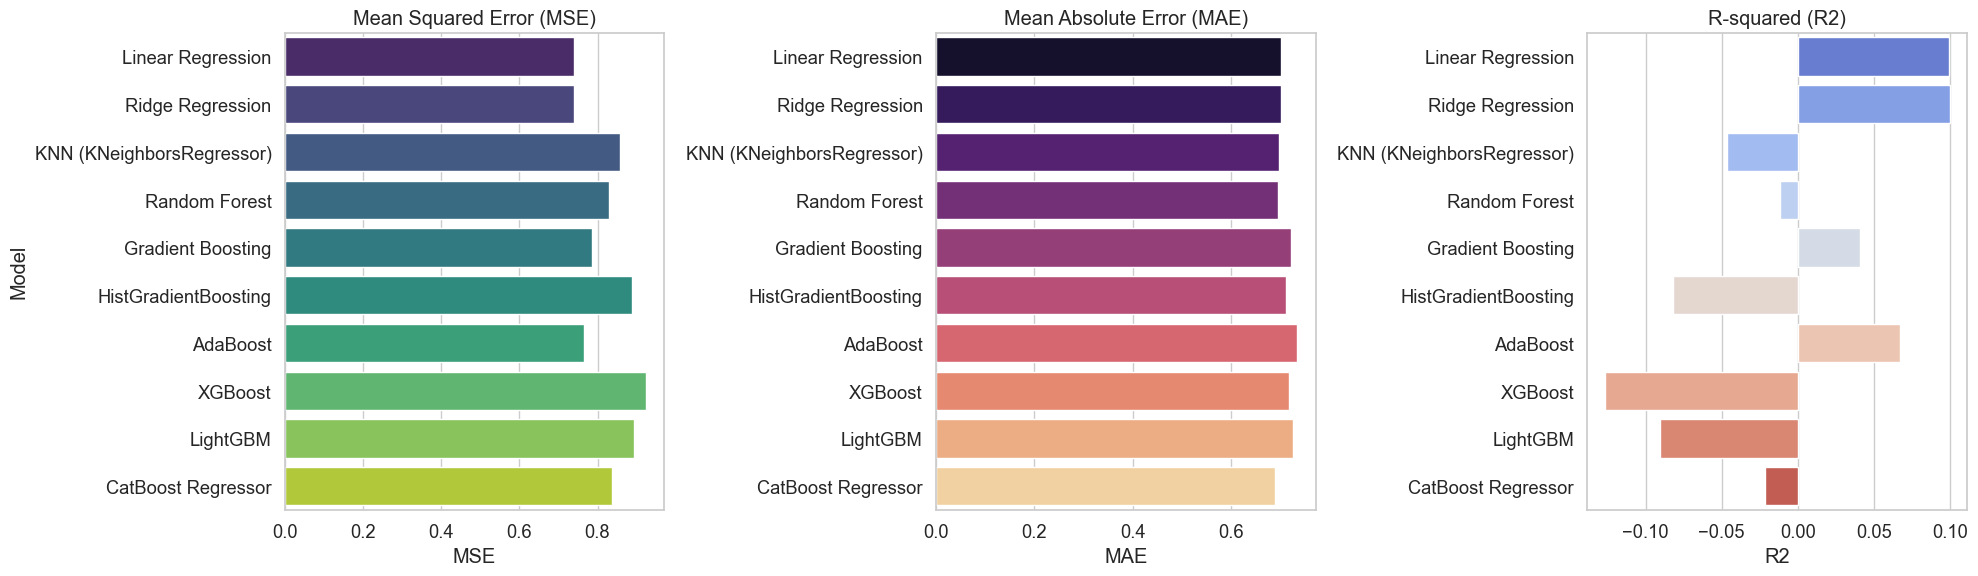

In [44]:
# визуализация результатов
results_df = pd.DataFrame(results).T  
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


results_df = pd.DataFrame(results).T 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(
    x='MSE',
    y=results_df.index,
    data=results_df,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')

sns.barplot(
    x='MAE',
    y=results_df.index,
    data=results_df,
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('')

sns.barplot(
    x='R2',
    y=results_df.index,
    data=results_df,
    ax=axes[2],
    palette='coolwarm'
)
axes[2].set_title('R-squared (R2)')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [45]:
# вычисление MAPE
results_mape = []

for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results_mape.append({'Модель': name, 'MAPE': mape})

results_df = pd.DataFrame(results_mape).sort_values(by='MAPE')

print(results_df.to_string(index=False))

                   Модель     MAPE
KNN (KNeighborsRegressor) 0.845246
         Ridge Regression 0.864684
        Linear Regression 0.864734
       CatBoost Regressor 0.879225
        Gradient Boosting 0.883402
                  XGBoost 0.890213
     HistGradientBoosting 0.894558
            Random Forest 0.897173
                 LightGBM 0.907911
                 AdaBoost 0.923570


In [46]:
# подбор гиперпараметров
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'KNN (KNeighborsRegressor)': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'HistGradientBoosting': {
        'model__max_iter': [100, 200],
        'model__max_depth': [None, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.01, 0.1]
    },
    'CatBoost Regressor': {
        'model__iterations': [100, 200],
        'model__depth': [4, 6],
        'model__learning_rate': [0.01, 0.1]
    }
}

results = []

for name in models:
    print(f"\nОбучение и подбор гиперпараметров для {name}...")
    
    grid = GridSearchCV(
        models[name],
        param_grids.get(name, {}),
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": best_params,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
     })

results_df = pd.DataFrame(results)
results_df['MSE'] = results_df['MSE'].round(3)
results_df['MAE'] = results_df['MAE'].round(3)
results_df['R2'] = results_df['R2'].round(3)

results_df['Best Params'] = results_df['Best Params'].apply(lambda x: str(x))

print("\nРезультаты моделей:")
print(tabulate(results_df.sort_values(by='R2'), headers='keys', tablefmt='fancy_grid', showindex=False))


Обучение и подбор гиперпараметров для Linear Regression...

Обучение и подбор гиперпараметров для Ridge Regression...

Обучение и подбор гиперпараметров для KNN (KNeighborsRegressor)...

Обучение и подбор гиперпараметров для Random Forest...

Обучение и подбор гиперпараметров для Gradient Boosting...

Обучение и подбор гиперпараметров для HistGradientBoosting...

Обучение и подбор гиперпараметров для AdaBoost...

Обучение и подбор гиперпараметров для XGBoost...

Обучение и подбор гиперпараметров для LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4905
[LightGBM] [Info] Number of data points in the train set: 744, number of used features: 29
[LightGBM] [Info] Start training from score 1.632240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai